In [1]:
import sys
sys.path.append('/home/xinyiz/pamrats')

import time
import os

import scanpy
import numpy as np
import scipy.sparse as sp

import torch
from torch import optim

import gae.gae.optimizer as optimizer
import gae.gae.model
import gae.gae.preprocessing as preprocessing

import pickle
import matplotlib.pyplot as plt
import seaborn as sns
import umap
import pandas as pd
from sklearn.preprocessing import scale
from sklearn.decomposition import PCA
from sklearn.preprocessing import MinMaxScaler
from sklearn.cluster import DBSCAN,MiniBatchKMeans,AgglomerativeClustering
from sklearn import metrics

import anndata as ad

In [8]:
inverseAct=True
minCells=15 #min number of cells for analysis
minCell_clusterDE=5
# clustermethod=['leiden','dbscan','agglomerative','kmeanbatch']
plotOnly=False
clustermethod=['leiden']
#umap/leiden clustering parameters
n_neighbors=10
min_dist=0.25
n_pcs=40 #for clustering
resolution=[0.1]
# resolution=[0.05,0.1,0.2,0.3]
plotepoch=9990
savenameAdd=''
#DBscan
epslist= [6,8,10]
min_sampleslist=[15,30,45] 
#agglomerative
nclusterlist=[2,3,4,5,8,10]
aggMetric=['euclidean']

#DE threshold
ntopgene=15 #for plots
fc=1.1
minIngroup=0.2
maxOutgroup=1
pvalthresh=0.05

combineCelltype={'glia':['Astro','Micro', 'OPC', 'Oligo'],'CA':['CA1', 'CA2', 'CA3']}

use_cuda=True
fastmode=False #Validate during training pass
seed=3
useSavedMaskedEdges=False
maskedgeName='knn20_connectivity'
# randFeatureSubset=None
adj_decodeName=None #gala or None
plot_samples={'disease13':'AD_mouse9494','control13':'AD_mouse9498','disease8':'AD_mouse9723','control8':'AD_mouse9735'}
plot_sample_X=['logminmax']
# plot_sample_X=['corrected','scaled']
standardizeX=False
name='allk20XA_02_dca_over'
logsavepath='/mnt/external_ssd//xinyi/log/train_gae_starmap/'+name
modelsavepath='/mnt/external_ssd/xinyi/models/train_gae_starmap/'+name
plotsavepath='/mnt/external_ssd/xinyi/plots/train_gae_starmap/'+name
    

In [3]:
# Set cuda and seed
np.random.seed(seed)
if use_cuda and (not torch.cuda.is_available()):
    print('cuda not available')
    use_cuda=False
torch.manual_seed(seed)
if use_cuda:
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.enabled = True


In [5]:
#Load data
# savedir=os.path.join('/mnt/xinyi/','starmap')
# adj_dir=os.path.join(savedir,'a')

featureslist={}
scaleddata=scanpy.read_h5ad('/home/xinyiz/2021-01-13-mAD-test-dataset/2020-12-27-starmap-mAD-raw.h5ad')

scalefactor={}
libsizeSum=0
for s in plot_samples.keys():
    scaleddata_train=scaleddata.X[scaleddata.obs['sample']==plot_samples[s]]

    libsizeS=np.sum(scaleddata_train,axis=1)
    scalefactorS=np.median(libsizeS)
    libsizeSum+=scalefactorS
    scalefactor[s]=scalefactorS
sizeFactor=libsizeSum/len(list(plot_samples.keys()))
for s in plot_samples.keys():
    scaleddata_train=scaleddata.X[scaleddata.obs['sample']==plot_samples[s]]
    
    featurelog_train=np.log2(scaleddata_train*(sizeFactor/scalefactor[s])+1/2)
    featureslist[s+'X_'+plot_sample_X[0]]=torch.tensor(featurelog_train)

feature_names=scaleddata.var.index

In [31]:
def de_singlesample(sample,labels,savepath,feature_names,plotOnly):
    if np.unique(labels).shape[0]==1:
        return
    var = pd.DataFrame(data=feature_names,index=feature_names,columns=['feature_names'])
    obs = pd.DataFrame()
    obs['clusterLabel']=labels
    adata = ad.AnnData(sample, obs=obs.astype('category'),var=var.astype('category'))
    if not plotOnly:
        scanpy.tl.rank_genes_groups(adata, 'clusterLabel',use_raw=False, method='wilcoxon',pts=True)
        with open(os.path.join(savepath), 'wb') as output:
            pickle.dump(adata.uns['rank_genes_groups'], output, pickle.HIGHEST_PROTOCOL)
    else:
        with open(os.path.join(savepath), 'rb') as input:
            adata.uns['rank_genes_groups']=pickle.load(input)
#     scanpy.tl.filter_rank_genes_groups(adata,groupby='clusterLabel',use_raw=False, min_fold_change=fc,min_in_group_fraction=minIngroup,max_out_group_fraction=maxOutgroup)
    genelist=np.array([])
#     print(adata.obs['clusterLabel'])
    for l in np.unique(labels).astype(str):
#         print(l)
        if l==-1:
            continue
        if np.sum(labels.astype(str)==l)<minCell_clusterDE or np.sum(labels.astype(str)!=l)<minCell_clusterDE:
            continue
        resl=scanpy.get.rank_genes_groups_df(adata, group=l,pval_cutoff=pvalthresh,gene_symbols='feature_names')
#         print(resl)
        reslup=resl[resl['logfoldchanges']>np.log2(fc)]
        resldown=resl[resl['logfoldchanges']< -np.log2(fc)]
        resl=resl[np.logical_or(resl['logfoldchanges']>np.log2(fc),resl['logfoldchanges']< -np.log2(fc))]
        
        np.savetxt(savepath+'UP_'+str(l)+'_fc'+str(fc)+'pvalue'+str(pvalthresh)+'.csv',np.array(reslup['names']).reshape((-1,1)),fmt='%s')
        np.savetxt(savepath+'Down_'+str(l)+'_fc'+str(fc)+'pvalue'+str(pvalthresh)+'.csv',np.array(resldown['names']).reshape((-1,1)),fmt='%s')
#         resl=resl[resl['pts']>minIngroup]
        resl=resl.sort_values('pvals_adj',axis=0)
        resl=resl.iloc[:np.min([resl.shape[0],ntopgene]),:]
        genelist=np.concatenate((genelist,resl['names']))
    if genelist.shape[0]==0:
        return
    scanpy.pl.dotplot(adata,np.unique(genelist),groupby='clusterLabel',use_raw=False,return_fig =True).savefig(savepath+'fc'+str(fc)+'ntop'+str(ntopgene)+'pvalue'+str(pvalthresh)+'.jpg')
    
# def plotEnrichment(clusterlabels,attributelabels,savepath):
#     labels=np.unique(clusterlabels)
#     attributes=np.unique(attributelabels)
    
#     for l in labels:
    
    
#     fig, ax = plt.subplots()

#     ax.bar(labels, men_means, width, yerr=men_std, label='Men')
#     ax.bar(labels, women_means, width, yerr=women_std, bottom=men_means,label='Women')

#     ax.set_ylabel('Scores')
#     ax.set_title('Scores by group and gender')
#     ax.legend()

#     plt.show()
#     return

def deLeiden(sample,n_neighbors,n_pcs,min_dist,resolution,feature_names,plotOnly=False,ctidx=None,clustersForDE=None):
    for r in resolution:
        savenamecluster='leiden_nn'+str(n_neighbors)+'mdist0'+str(int(min_dist*100))+'n_pcs'+str(n_pcs)+'res'+str(r)+'epoch'+str(plotepoch)
        readpath=os.path.join(clustersavedir,savenamecluster)
        if not os.path.exists(readpath):
            print('DNE: '+readpath)
            continue
        with open(readpath, 'rb') as input:
            labels = pickle.load(input)
        if clustersForDE is None:
            clustersForDE=np.unique(labels)
        else:
            savenamecluster+='_clusters'
            for c in clustersForDE:
                savenamecluster+=c
        if ctidx is not None:
            clusterincluded=np.repeat(False,ctidx.size)
            for c in np.unique(labels[ctidx]):
                if np.sum(labels[ctidx]==c)>1 and (c in clustersForDE):
                    clusterincluded=np.logical_or(clusterincluded,labels==c)
            ctidx=np.logical_and(ctidx,clusterincluded)
            if np.sum(ctidx)<minCells:
                continue
            de_singlesample(sample[ctidx],labels[ctidx],os.path.join(desavedir_ct,savenamecluster),feature_names,plotOnly)
        else:
            clusterincluded=np.repeat(False,labels.size)
            for c in clustersForDE:
                clusterincluded=np.logical_or(clusterincluded,labels==c)
            de_singlesample(sample[clusterincluded],labels[clusterincluded],os.path.join(desavedir,savenamecluster),feature_names,plotOnly)

def deDBscan(sample,epsL,min_samplesL,n_pcs,feature_names,plotOnly=False):
    for eps in epsL:
        for min_samples in min_samplesL:
            savenamecluster='dbscan_eps'+str(eps)+'msamples'+str(min_samples)+'n_pcs'+str(n_pcs)+'epoch'+str(plotepoch)
            readpath=os.path.join(clustersavedir,savenamecluster)
            if not os.path.exists(readpath):
                print('DNE: '+readpath)
                continue
            with open(readpath, 'rb') as input:
                labels = pickle.load(input)
            de_singlesample(sample,labels,os.path.join(desavedir,savenamecluster),feature_names,plotOnly)
                
def deAgg(sample,nclusterL,aggmetricL,n_pcs,feature_names,plotOnly=False):
    for ncluster in nclusterL:
        for aggmetric in aggmetricL:
            savenamecluster='agg_ncluster'+str(ncluster)+aggmetric+'n_pcs'+str(n_pcs)+'epoch'+str(plotepoch)
            readpath=os.path.join(clustersavedir,savenamecluster)
            if not os.path.exists(readpath):
                print('DNE: '+readpath)
                continue
            with open(readpath, 'rb') as input:
                labels = pickle.load(input)
            de_singlesample(sample,labels,os.path.join(desavedir,savenamecluster),feature_names,plotOnly)
            
def deMinibatchKmean(sample,nclusterL,n_pcs,feature_names,plotOnly=False):
    for ncluster in nclusterL:
        savenamecluster='minibatchkmean_ncluster'+str(ncluster)+'n_pcs'+str(n_pcs)+'epoch'+str(plotepoch)
        readpath=os.path.join(clustersavedir,savenamecluster)
        if not os.path.exists(readpath):
            print('DNE: '+readpath)
            continue
        with open(readpath, 'rb') as input:
            labels = pickle.load(input)
        de_singlesample(sample,labels,os.path.join(desavedir,savenamecluster),feature_names,plotOnly)
                

In [34]:
clustersForDE=['0','1','3']

/home/xinyiz/anaconda3/envs/pytorch/lib/python3.8/site-packages/anndata/_core/anndata.py:120: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)
/home/xinyiz/anaconda3/envs/pytorch/lib/python3.8/site-packages/scanpy/tools/_rank_genes_groups.py:419: RuntimeWarning: invalid value encountered in log2
  self.stats[group_name, 'logfoldchanges'] = np.log2(
/home/xinyiz/anaconda3/envs/pytorch/lib/python3.8/site-packages/anndata/_core/anndata.py:120: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)
/home/xinyiz/anaconda3/envs/pytorch/lib/python3.8/site-packages/scanpy/tools/_rank_genes_groups.py:419: RuntimeWarning: invalid value encountered in log2
  self.stats[group_name, 'logfoldchanges'] = np.log2(
/home/xinyiz/anaconda3/envs/pytorch/lib/python3.8/site-packages/anndata/_core/anndata.py:120: ImplicitModificationWarning: Transformin

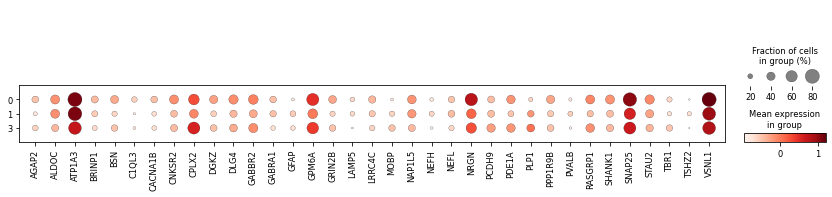

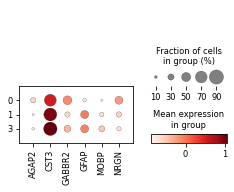

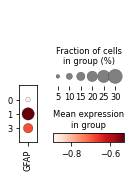

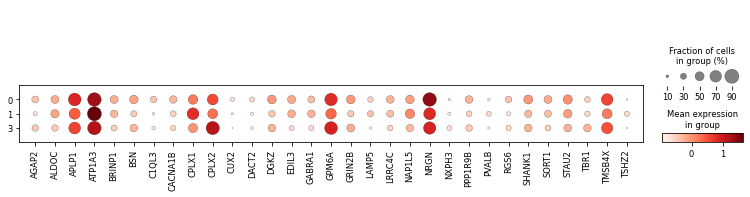

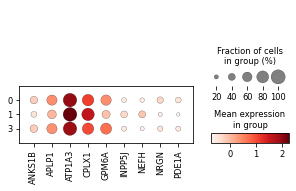

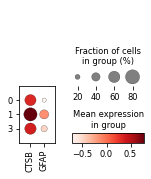

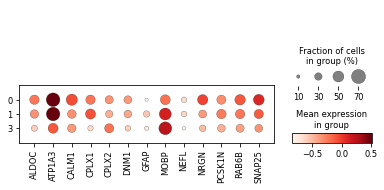

In [36]:
# combine all latents to one plot 
for xcorr in plot_sample_X:
    celltype_broad=None
    celltype_sub=None
    region=None
#     samplenameList=None
    featureDE=None
#     sobj_coord_np=None
    
    for s in plot_samples.keys():
        sampleidx=plot_samples[s]        
        samplename=s+'X_'+xcorr
        featureDEs=np.copy(featureslist[samplename])
            
        if featureDE is None:
            featureDE=featureDEs
            celltype_broad=scaleddata.obs.loc[scaleddata.obs['sample']==sampleidx,'top_level']
            celltype_sub=scaleddata.obs.loc[scaleddata.obs['sample']==sampleidx,'cell_type_label']
            region=scaleddata.obs.loc[scaleddata.obs['sample']==sampleidx,'region']
#             sobj_coord_np=scaleddata.obs.loc[scaleddata.obs['sample']==sampleidx,['x','y']].to_numpy()
#             samplenameList=np.repeat(s,muplot.shape[0])
        else:
            featureDE=np.vstack((featureDE,featureDEs))
            celltype_broad=np.concatenate((celltype_broad,scaleddata.obs.loc[scaleddata.obs['sample']==sampleidx,'top_level']),axis=None)
            celltype_sub=np.concatenate((celltype_sub,scaleddata.obs.loc[scaleddata.obs['sample']==sampleidx,'cell_type_label']),axis=None)
            region=np.concatenate((region,scaleddata.obs.loc[scaleddata.obs['sample']==sampleidx,'region']),axis=None)
#             sobj_coord_np=np.concatenate((sobj_coord_np,scaleddata.obs.loc[scaleddata.obs['sample']==sampleidx,['x','y']].to_numpy()),axis=0)
#             samplenameList=np.concatenate((samplenameList,np.repeat(s,muplot.shape[0])),axis=None)
       
    origCT=np.unique(celltype_broad)
    celltypeplot=np.concatenate((origCT,list(combineCelltype.keys())),axis=None)
    sampledir=os.path.join(plotsavepath,'combined'+xcorr)
    if inverseAct:
        sampledir+='_beforeAct'
    clustersavedir=os.path.join(sampledir,'cluster')
    desavedir=os.path.join(sampledir,'de')
    if not os.path.exists(desavedir):
        os.mkdir(desavedir)
    
    
    if featureDE.shape[0]<minCells:
        continue
    if 'leiden' in clustermethod:
#         deLeiden(featureDE,n_neighbors,n_pcs,min_dist,resolution,feature_names)
        deLeiden(featureDE,n_neighbors,n_pcs,min_dist,resolution,feature_names,clustersForDE=clustersForDE)
    if 'dbscan' in clustermethod:
        deDBscan(featureDE,epslist,min_sampleslist,n_pcs,feature_names)
    if 'agglomerative' in clustermethod:
        deAgg(featureDE,nclusterlist,aggMetric,n_pcs,feature_names)
    if 'kmeanbatch' in clustermethod:
        deMinibatchKmean(featureDE,nclusterlist,n_pcs,feature_names)
    for ct in np.unique(celltype_broad):
        ctidx=celltype_broad==ct
        if np.sum(ctidx)<minCells:
            continue
        desavedir_ct=os.path.join(desavedir,ct)
        if not os.path.exists(desavedir_ct):
            os.mkdir(desavedir_ct)
        if 'leiden' in clustermethod:
#             deLeiden(featureDE,n_neighbors,n_pcs,min_dist,resolution,feature_names,ctidx=ctidx)
            deLeiden(featureDE,n_neighbors,n_pcs,min_dist,resolution,feature_names,ctidx=ctidx,clustersForDE=clustersForDE)
#     #by region
# #     for reg in np.unique(region):
#     for reg in ['Hippocampus']:
# #         savedir=os.path.join(sampledir,'embedding_'+plottype+'_'+reg)
# #         clustersavedir=os.path.join(sampledir,'cluster'+'_'+reg)
# #         if not os.path.exists(savedir):
# #             os.mkdir(savedir)
# #         if not os.path.exists(clustersavedir):
# #             os.mkdir(clustersavedir)

#         reg_idx=region==reg

        
# #         if embedding.shape[0]<minCells:
# #             continue
# #         if ifcluster:
# #             if 'leiden' in clustermethod:
# #                 clusterLeiden_allsample(latents[reg_idx],n_neighbors,n_pcs,min_dist,resolution,sobj_coord_np[reg_idx],samplenameList[reg_idx],randseed=seed)
# #             if 'dbscan' in clustermethod:
# #                 clusterDBscan_allsample(latents[reg_idx],epslist,min_sampleslist,n_pcs,sobj_coord_np[reg_idx],samplenameList[reg_idx])
# #             if 'agglomerative' in clustermethod:
# #                 clusterAgg_allsample(latents[reg_idx],nclusterlist,aggMetric,n_pcs,sobj_coord_np[reg_idx],samplenameList[reg_idx])
                    
#         #by region and celltype
# #         for ct in celltypeplot:
#         for ct in ['CA1']:
#             clustersavedir=os.path.join(sampledir,'cluster'+'_'+reg+ct)
#             desavedir=os.path.join(sampledir,'de'+'_'+reg+ct)
#             if not os.path.exists(desavedir):
#                 os.mkdir(desavedir)

            
#             if ct in origCT:
#                 ct_idx=celltype_broad==ct
#             else:
#                 ct_idx=False
#                 for i in combineCelltype[ct]:
#                     ct_idx=np.logical_or(ct_idx,celltype_broad==i)
#             ct_idx=np.logical_and(reg_idx,ct_idx)      
            
#             if np.sum(ct_idx)<minCells:
#                 continue
#             if 'leiden' in clustermethod:
#                 deLeiden(featureDE[ct_idx],n_neighbors,n_pcs,min_dist,resolution,feature_names)
#             if 'dbscan' in clustermethod:
#                 deDBscan(featureDE[ct_idx],epslist,min_sampleslist,n_pcs,feature_names)
#             if 'agglomerative' in clustermethod:
#                 deAgg(featureDE[ct_idx],nclusterlist,aggMetric,n_pcs,feature_names)
#             if 'kmeanbatch' in clustermethod:
#                 deMinibatchKmean(featureDE[ct_idx],nclusterlist,n_pcs,feature_names)
#     #by celltype
# #     for ct in celltypeplot:
# #         savedir=os.path.join(sampledir,'embedding_'+plottype+'_'+ct)
# #         clustersavedir=os.path.join(sampledir,'cluster'+'_'+ct)
# #         if not os.path.exists(savedir):
# #             os.mkdir(savedir)
# #         if not os.path.exists(clustersavedir):
# #             os.mkdir(clustersavedir)

# #         if ct in origCT:
# #             ct_idx=celltype_broad==ct
# #         else:
# #             ct_idx=False
# #             for i in combineCelltype[ct]:
# #                 ct_idx=np.logical_or(ct_idx,celltype_broad==i)

        
# #         if embedding.shape[0]<minCells:
# #             continue
# #         if ifcluster:
# #             if 'leiden' in clustermethod:
# #                 clusterLeiden_allsample(latents[ct_idx],n_neighbors,n_pcs,min_dist,resolution,sobj_coord_np[ct_idx],samplenameList[ct_idx],randseed=seed)
# #             if 'dbscan' in clustermethod:
# #                 clusterDBscan_allsample(latents[ct_idx],epslist,min_sampleslist,n_pcs,sobj_coord_np[ct_idx],samplenameList[ct_idx])
# #             if 'agglomerative' in clustermethod:
# #                 clusterAgg_allsample(latents[ct_idx],nclusterlist,aggMetric,n_pcs,sobj_coord_np[ct_idx],samplenameList[ct_idx])